# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [1]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/kylecm11/silver_fund/sf-quant-labs/.venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-09-13 15:00:28,514	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [2]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [9]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    data = data.sort(['barrid', 'date'])
    
    # Calculate momentum using a rolling window
    
    data = data.with_columns(
        (pl.col('return') / 100 + 1).log().rolling_sum(window_size=230).shift(22).alias('momentum')
    )
    
    return data.select(['date', 'barrid', 'price', 'return', 'momentum']).drop_nulls()

momentum = task_compute_momentum(data)

momentum

date,barrid,price,return,momentum
date,str,f64,f64,f64
2014-07-30,"""USA06Z1""",7.1,0.9957,0.101525
2014-07-31,"""USA06Z1""",6.91,-2.6761,0.124505
2014-08-01,"""USA06Z1""",6.81,-1.4472,0.167176
2014-08-04,"""USA06Z1""",7.08,3.9648,0.159344
2014-08-05,"""USA06Z1""",7.05,-0.4237,0.14279
…,…,…,…,…
2024-12-24,"""USBQOR1""",70.58,2.5872,-0.197908
2024-12-26,"""USBQOR1""",73.61,4.293,-0.12738
2024-12-27,"""USBQOR1""",69.85,-5.108,-0.18634


## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [10]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """

    momentum = momentum.with_columns(
        pl.col('price').shift(1).alias('lagged_price')
    )
    return momentum.filter(
        (pl.col('lagged_price') > 5) & pl.col('momentum').is_not_null()
    ).select(['date', 'barrid', 'price', 'return', 'momentum'])
    

price_filter = task_price_filter(momentum)

price_filter

date,barrid,price,return,momentum
date,str,f64,f64,f64
2014-07-31,"""USA06Z1""",6.91,-2.6761,0.124505
2014-08-01,"""USA06Z1""",6.81,-1.4472,0.167176
2014-08-04,"""USA06Z1""",7.08,3.9648,0.159344
2014-08-05,"""USA06Z1""",7.05,-0.4237,0.14279
2014-08-06,"""USA06Z1""",6.98,-0.9929,0.144795
…,…,…,…,…
2024-12-24,"""USBQOR1""",70.58,2.5872,-0.197908
2024-12-26,"""USBQOR1""",73.61,4.293,-0.12738
2024-12-27,"""USBQOR1""",69.85,-5.108,-0.18634


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [28]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    return price_filter.with_columns(pl.col('momentum').qcut(10).cast(pl.Int32).alias('bin')).sort(['date', 'bin'])
                                     

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,price,return,momentum,bin
date,str,f64,f64,f64,i32
1996-01-02,"""USAMUQ2""",12.0,4.3478,0.12144,0
1996-01-02,"""USAHE41""",39.125,3.3003,0.082195,0
1996-01-02,"""USACYN1""",18.5,4.9645,0.13163,0
1996-01-02,"""USAHL51""",6.875,5.7692,0.147678,0
1996-01-02,"""USAO4M1""",29.375,0.8584,0.115732,0
…,…,…,…,…,…
2024-12-31,"""USALG41""",44.55,1.25,-0.583512,9
2024-12-31,"""USBDRB1""",10.42,3.1683,-0.525102,9
2024-12-31,"""USBDID1""",17.23,0.2327,-0.635448,9


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [58]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    return momentum_bins.group_by(['date', 'bin']).agg(
        pl.col('return').mean().alias('equal_weight_return')
    ).sort(['date', 'bin']).pivot(
        index='date',
        columns='bin',
        values='equal_weight_return'
    ).with_columns((pl.col('9') - pl.col('0')).alias('spread'))

momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

/tmp/ipykernel_1402692/1807670846.py:13: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  ).sort(['date', 'bin']).pivot(


date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-01-02,0.955142,0.635341,0.536033,0.758831,0.645837,0.00603,0.479062,0.573414,0.696204,0.715943,-0.239199
1996-01-03,-0.517597,0.094406,-0.210699,-0.410821,-0.357763,-0.212747,0.077896,-0.079679,-0.403146,-0.373916,0.143681
1996-01-04,-1.267103,-1.069757,-0.927356,-1.225223,-1.322804,-1.151639,-0.664057,-1.056988,-1.049455,-0.965347,0.301755
1996-01-05,0.546098,0.4249,0.431043,0.347125,0.256326,0.48049,0.493661,0.130209,0.289178,0.370512,-0.175586
1996-01-08,0.017171,0.012718,-0.017807,-0.001166,0.076618,-0.035134,0.162525,0.039135,-0.027866,0.042615,0.025444
…,…,…,…,…,…,…,…,…,…,…,…
2024-12-24,0.777991,0.84517,0.656347,1.396209,1.087551,0.848264,0.855468,0.82585,0.852381,0.787503,0.009512
2024-12-26,0.480006,0.425792,0.53989,1.170198,0.749281,0.376766,0.669083,0.780565,1.114878,1.908519,1.428513
2024-12-27,-1.184253,-1.225445,-1.059008,-2.001595,-1.388803,-1.221995,-1.134383,-1.183128,-1.278446,-1.548518,-0.364266


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [ ]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    return momentum_portfolios.unpivot(index='date', variable_name='bin', value_name='equal_weight_return').with_columns(
        ((pl.col("equal_weight_return") / 100 + 1).log()
         .cum_sum().over("bin"))
        .alias("cumulative_log_return")
    )


momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

date,bin,equal_weight_return,cumulative_log_return
date,str,f64,f64
1996-01-02,"""0""",0.955142,0.009506
1996-01-03,"""0""",-0.517597,0.004317
1996-01-04,"""0""",-1.267103,-0.008435
1996-01-05,"""0""",0.546098,-0.002989
1996-01-08,"""0""",0.017171,-0.002817
…,…,…,…
2024-12-24,"""spread""",0.009512,-3.379048
2024-12-26,"""spread""",1.428513,-3.364864
2024-12-27,"""spread""",-0.364266,-3.368513


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

<Axes: xlabel='date', ylabel='cumulative_log_return'>

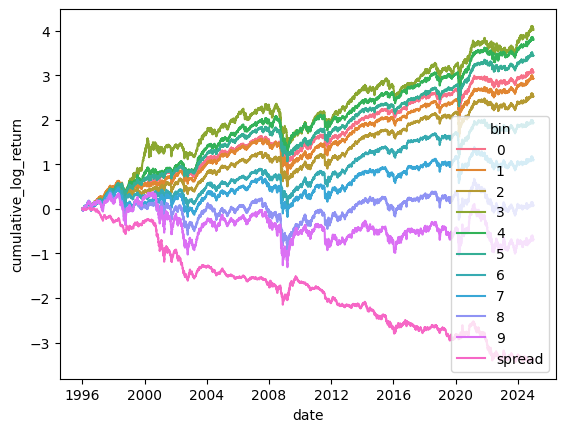

In [60]:
sns.lineplot(data=momentum_returns, x='date', y='cumulative_log_return', hue='bin')

In [78]:
def performance_metrics(returns: pl.DataFrame) -> dict:
    average_return = returns.select(pl.col('return').mean()).item() * np.sqrt(252)
    volatility = returns.select(pl.col('return').std()).item() * np.sqrt(252)
    sharpe = average_return / volatility * np.sqrt(252)

    return {
        'average_return': average_return,
        'volatility': volatility,
        'sharpe': sharpe
    }

for i in range(10):
    print(f"Bin {i}: {performance_metrics(momentum_returns.filter(pl.col('bin') == str(i)).with_columns(pl.col('equal_weight_return').alias('return')))}")

print(f"Spread: {performance_metrics(momentum_returns.filter(pl.col('bin') == 'spread').with_columns(pl.col('equal_weight_return').alias('return')))}")


Bin 0: {'average_return': np.float64(0.781594284268092), 'volatility': np.float64(19.067620628237595), 'sharpe': np.float64(0.6507064964132432)}
Bin 1: {'average_return': np.float64(0.7503885483829205), 'volatility': np.float64(19.05938259969064), 'sharpe': np.float64(0.6249965785536594)}
Bin 2: {'average_return': np.float64(0.6668575217025856), 'volatility': np.float64(19.33721904340435), 'sharpe': np.float64(0.5474435052044437)}
Bin 3: {'average_return': np.float64(1.097689715948132), 'volatility': np.float64(26.531573296824973), 'sharpe': np.float64(0.6567753761046885)}
Bin 4: {'average_return': np.float64(0.9692208326755132), 'volatility': np.float64(21.217488517050516), 'sharpe': np.float64(0.7251519764089848)}
Bin 5: {'average_return': np.float64(0.8689657427052011), 'volatility': np.float64(19.606430450542813), 'sharpe': np.float64(0.7035652692105974)}
Bin 6: {'average_return': np.float64(0.5475824527205124), 'volatility': np.float64(20.16542147513442), 'sharpe': np.float64(0.43